3: RESEAU DE NEURONES

Préparation des données: (pareil)

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(1074, 10)
(1074,)


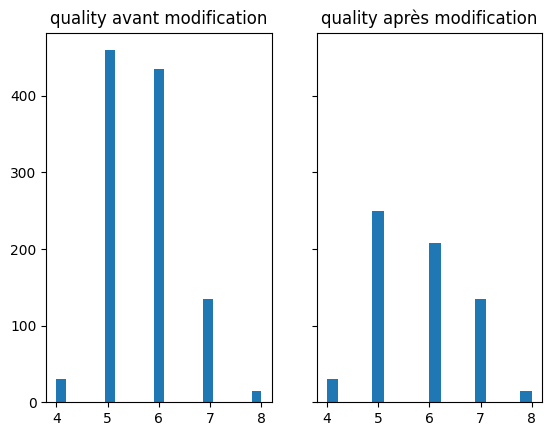

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
df = pd.read_csv('WineQT.csv')
import numpy as np
import matplotlib.pyplot as plt

def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

#On normalise : mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)


normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
#plot_hists(df)

standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
#plot_hists(df)

import numpy as np
import matplotlib.pyplot as plt

#Préparation des données
y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)


#on supprime aleatoirement des valeurs de notes 5 et 6 (diviser par 2)
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

Creation de 3 modèles à comparer:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from IPython.display import display, Markdown, Latex
from matplotlib.widgets import Slider
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

2023-04-30 15:21:16.310134: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 15:21:16.350386: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 15:21:16.351288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 15:21:17.062594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.random.set_seed(20)

In [3]:

def build_models():
    
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]

    return model_list

In [4]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
def build_models_softmax():
    model = Sequential(
            [
                tf.keras.Input(shape=(2,)),
                Dense(120, activation = 'relu'),
                Dense(40, activation = 'relu'),
                Dense(6, activation = 'linear')
            ],
            name="Complex"
    )
        
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )
    return model

In [6]:
def locateMax(tab):
    max=0
    for loop in range(len(tab)):
        if tab[loop]>tab[max]:
            max=loop
    return max

In [16]:

def sigmoid(z):
    g = 1/(1+np.exp(-z))
    return g

def calcul_error(yhat,y_test):
   
    cost = 0.0
    m=len(y_test)
    for i in range(m):                                
        cost = cost + (y_test[i] - yhat[i])**2   #scalar
    cost = cost / (2 * m)                 #scalar    
    return cost

In [14]:
# Setup the loss and optimizer
def try_model(model):
    
    model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")
    
    
    # Train the model
    model.fit(
        X_train, y_train,
        epochs=200,
        verbose=0
    )
    print("Done!\n")

    # Record the fraction of misclassified examples for the training set
    predictions = model.predict(X_train)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    train_error = calcul_error(yhat,y_train)

    # Record the fraction of misclassified examples for the cross validation set
    predictions = model.predict(X_cv)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    #print(yhat)

    cv_error = calcul_error(yhat,y_cv)
    return(train_error,cv_error)

In [17]:

from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models = build_models()

# Loop over the the models
for model in nn_models:
    
    train_error,cv_error=try_model(model)
    nn_train_error.append(train_error)
    nn_cv_error.append(cv_error)

    
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

4/4 [==============================] - 0s 1ms/step
Training model_2...
Done!

4/4 [==============================] - 0s 1ms/step
Training model_3...
Done!

4/4 [==============================] - 0s 1ms/step
Model 1: Training Set Classification Error: 0.30497, CV Set Classification Error: 0.37402
Model 2: Training Set Classification Error: 0.24476, CV Set Classification Error: 0.29921
Model 3: Training Set Classification Error: 0.27749, CV Set Classification Error: 0.32283


In [31]:
def predict_model(model):
# Select the model with the lowest error

    # Compute the test error
    predictions = model.predict(X_test)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])
    print(yhat)
    print(y_test)
    print(f"Selected Model: {model_num}")
    sum=0
    for loop in range(len(yhat)):
        if(y_test[loop] == yhat[loop]):
            sum+=1
    print('Train Accuracy (%): ',(sum/len(yhat))*100)

    nn_test_error =calcul_error(yhat,y_test)


    print(f"Training Set Classification Error: {nn_train_error[model_num-1]:.4f}")
    print(f"CV Set Classification Error: {nn_cv_error[model_num-1]:.4f}")
    print(f"Test Set Classification Error: {nn_test_error:.4f}")

In [32]:
model_num = 2
model=nn_models[model_num-1]
predict_model(model)



4/4 [==============================] - 0s 2ms/step
[6. 7. 7. 6. 5. 5. 5. 5. 6. 7. 7. 7. 6. 5. 5. 6. 7. 6. 7. 5. 7. 6. 7. 5.
 6. 5. 5. 5. 5. 6. 6. 5. 5. 5. 6. 5. 7. 5. 7. 5. 7. 5. 5. 6. 6. 5. 6. 5.
 6. 6. 6. 5. 5. 5. 5. 5. 5. 6. 5. 6. 7. 5. 5. 5. 5. 5. 7. 6. 5. 6. 6. 5.
 6. 6. 7. 6. 7. 6. 5. 6. 7. 6. 6. 5. 5. 5. 5. 5. 5. 5. 7. 5. 5. 5. 6. 5.
 5. 5. 5. 6. 6. 5. 6. 7. 5. 6. 6. 6. 5. 5. 6. 5. 7. 6. 5. 6. 5. 6. 7. 6.
 6. 5. 5. 5. 6. 5. 6. 6.]
[7 6 6 8 5 6 5 5 6 5 6 7 5 5 5 7 8 6 7 6 7 6 7 4 7 5 6 5 5 7 5 6 6 6 5 6 7
 5 6 6 6 5 5 8 6 6 6 6 6 6 7 5 5 5 5 5 6 6 6 5 7 5 5 6 6 5 8 6 6 6 7 5 6 5
 8 5 6 7 6 7 7 5 6 6 6 5 5 7 5 5 7 5 5 6 7 5 5 5 5 6 4 5 6 7 5 5 8 7 6 5 6
 5 8 6 6 5 5 6 7 6 6 6 5 5 7 6 7 7]
Selected Model: 2
Train Accuracy (%):  51.5625
Training Set Classification Error: 0.2448
CV Set Classification Error: 0.2992
Test Set Classification Error: 0.3125


VISUALISATION TEST DU MODELE CHOISI 

In [20]:
def plot_predict_model(model):
    predictions = model.predict(X_cv)
    yhat= np.zeros(len(predictions))

    for loop in range(len(predictions)):
        yhat[loop]=locateMax(predictions[loop])

    print(X_test.shape, y_test.shape,yhat.shape)


    m = X_test.shape[0]

        # plot predictions and targets versus original features    
    fig,ax=plt.subplots(1,nb_feature,figsize=(20, 3),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter([X_test[:,i]],y_test, label = 'target')
        ax[i].set_xlabel(X_features[i])
        ax[i].scatter([X_test[:len(yhat),i]],yhat,color="orange", label = 'predict')
    ax[0].set_ylabel("Quality"); ax[0].legend()
    fig.suptitle("target versus prediction using Reseau de Neurones avec Softmax")
    plt.show()

4/4 [==============================] - 0s 1ms/step
(128, 10) (128,) (127,)


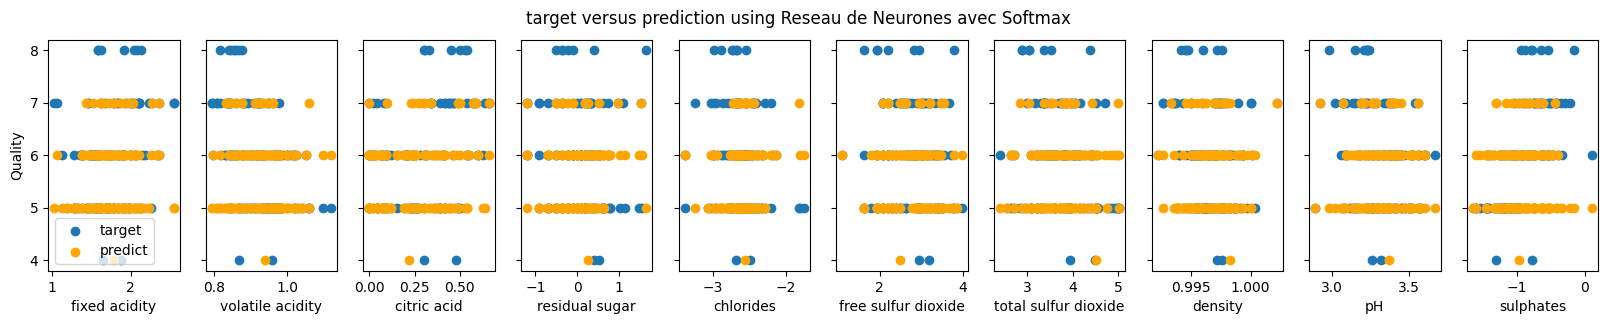

In [21]:
model_num = 2
model=nn_models[model_num-1]
plot_predict_model(model)


FIXER BIAIS ET VARIANCES:

INFLUENCE DE LAMBDA:

vu que Jcv (49.1379) est grand par rapport à Jtrain (14.4092), on a une grande variance, on va donc rajouter un parametre de régularisation Lambda en gardant le meme model.

In [22]:
from tensorflow.keras.regularizers import l2
def build_models_Regularized():
    lambdas=[0.00,0.01,0.1]
    model_1 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[0])),
            Dense(9, activation = 'softmax')
        ],
        name='model_1'
    )
    model_2 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[1])),
            Dense(9, activation = 'softmax')
        ],
        name='model_2'
    )
    model_3 = Sequential(
        [
            tf.keras.Input(shape=(nb_feature,)),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(12, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(20, activation = 'relu',kernel_regularizer=l2(lambdas[2])),
            Dense(9, activation = 'softmax')
        ],
        name='model_3'
    )
    model_list = [model_1, model_2, model_3]
    return model_list

In [23]:
from sklearn.metrics import mean_squared_error
# Initialize lists that will contain the errors for each model
nn_train_error = []
nn_cv_error = []


# Build the models
nn_models_r = build_models_Regularized()

# Loop over the the models
for model in nn_models_r:
    
    train_error,cv_error=try_model(model)
    nn_train_error.append(train_error)
    nn_cv_error.append(cv_error)
    
# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

4/4 [==============================] - 0s 2ms/step
Training model_2...
Done!

4/4 [==============================] - 0s 3ms/step
Training model_3...
Done!

4/4 [==============================] - 0s 2ms/step
Model 1: Training Set Classification Error: 2.84900, CV Set Classification Error: 64.10256
Model 2: Training Set Classification Error: 27.35043, CV Set Classification Error: 45.29915
Model 3: Training Set Classification Error: 59.82906, CV Set Classification Error: 76.06838


In [24]:
# Select the model with the lowest error
model_num = 2
model=nn_models_r[model_num-1]
predict_model(model)


4/4 [==============================] - 0s 4ms/step
[7. 5. 7. 5. 5. 5. 7. 5. 5. 7. 6. 7. 6. 6. 6. 5. 5. 6. 5. 5. 5. 5. 6. 7.
 5. 5. 5. 7. 5. 6. 5. 5. 5. 7. 7. 6. 6. 7. 6. 6. 7. 5. 5. 5. 6. 6. 6. 6.
 5. 7. 5. 7. 7. 7. 7. 6. 7. 6. 7. 5. 6. 6. 6. 5. 6. 5. 7. 7. 7. 5. 7. 5.
 5. 5. 7. 5. 6. 6. 7. 5. 5. 6. 5. 6. 7. 6. 6. 6. 5. 5. 6. 6. 7. 6. 5. 7.
 6. 6. 7. 6. 6. 7. 5. 5. 6. 5. 5. 5. 7. 6. 7. 7. 7. 6. 6. 6. 6. 6.]
[6 3 6 5 5 5 6 5 6 6 6 6 5 5 5 5 5 6 5 6 5 6 6 6 5 5 5 6 5 5 5 5 8 6 7 6 6
 6 5 5 7 5 5 5 4 5 5 7 5 5 6 8 7 7 7 6 6 5 7 4 6 5 7 4 7 3 5 5 7 5 7 3 4 5
 6 5 7 6 6 6 3 6 6 6 5 5 6 6 5 5 5 5 6 6 5 7 6 5 7 5 5 8 5 5 7 5 5 5 6 6 6
 5 7 6 6 5 6 5]
Selected Model: 2
Training Set Classification Error: 27.3504
CV Set Classification Error: 45.2991
Test Set Classification Error: 50.8475


On a un grand biais, il faut ajouter des features ou des polynomial features (alcohol^2, alcohol*sulfates...)